In [173]:
from MesoPy import Meso
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd

In [13]:
m = Meso(token='0191c61bf7914bd49b8bd7a98abb9469')
precip = m.precip(stid='kfnl', start='201504241800', end='201504271200', units='precip|in')

In [28]:
from glob import glob
import rasterio as rio

In [29]:
# glob('/scratch/zacharykeskinen/jpl/*/tiffs/*')
fp = '/scratch/zacharykeskinen/jpl/lowman_23205_21019-018_21021-006_0006d_s01_L090_01_int_grd/tiffs/lowman_23205_21019-018_21021-006_0006d_s01_L090HH_01.cor.grd.tiff'
with rio.open(fp) as src:
    bounds  = src.bounds
    

In [30]:
bounds

BoundingBox(left=-116.37314244000001, bottom=43.59365388, right=-114.98658708, top=44.48572524)

bbox: list, optional
    Stations within a [lon/lat] box in the order [lonmin,latmin,lonmax,latmax] e.g. bbox="-120,40,-119,41"

In [80]:
for stat in m.metadata(start = '202002010000', end = '202002100000', bbox = bounds)['STATION']:
    name = stat['NAME']
    long = stat['LONGITUDE']
    lat = stat['LATITUDE']
    elev = stat['ELEVATION']
    stid = stat['STID']
    status = stat['STATUS']
    print(name)
    print(lat)
    print(long)
    print(stid)

BOISE
43.60028
-116.17667
BOII
ATLANTA SUMMIT
43.75690
-115.23907
ATAI1
BANNER SUMMIT
44.30342
-115.23447
BASI1
BOGUS BASIN
43.76377
-116.09685
BOGI1
COZY COVE
44.28783
-115.65527
COZI1
GRAHAM GUARD STA.
43.95380
-115.27387
GGSI1
JACKSON PEAK
44.05092
-115.44322
JKPI1
MORES CREEK SUMMIT
43.93200
-115.66588
MRKI1
TRINITY MTN.
43.62903
-115.43818
TRMI1
BANNER SUMMIT
44.3
-115.23
TMPE7
BEARSKIN CREEK
44.385556
-115.5505
BCFI1
CANYON CREEK
44.23
-115.25
TMPE8
CLASS III 7-C
43.6
-116.21
QEDA3
CRANE CREEK
43.67
-116.13
CRNI1
CURLEW CREEK
43.64
-116.13
CURI1
FIRE RAWS #1
43.6
-116.21
CBPN5
FIRE RAWS #2
43.6
-116.21
SIGN5
LITTLE ANDERSON
44.091111
-115.880556
LTAI1
PINE CREEK
44.250278
-116.198611
PNFI1
TOWN CREEK
43.939583
-115.911528
TCFI1
CLASS III NPS7
43.5994
-116.2081
TS321
CLASS III NPS3
43.5994
-116.2081
TS323
CLASS III NPS5
43.5994
-116.2081
TS324
CLASS III NPS1
43.5994
-116.2081
TS326
CLASS III NPS4
43.5994
-116.2081
TS327
CLASS III NPS2
43.5994
-116.2081
TS329
FRWS-01
43.5994
-116.2

In [125]:
def raster_box_extract(img, x_coord, y_coord, box_side = 5):
    meta = img.meta

    # Use the transform in the metadata and your coordinates
    try:
        rowcol = rio.transform.rowcol(meta['transform'], xs=x_coord, ys=y_coord)
        w = img.read(1, window=Window(rowcol[1], rowcol[0], box_side, box_side))
        return w
    except:
        pass
        # print('station outside bbox')

In [256]:
stat_ls = []
stid_ls = []
res = {}
for stat in m.metadata(start = start_flight, end = end_flight, bbox = bounds)['STATION']:
    long = float(stat['LONGITUDE'])
    lat = float(stat['LATITUDE'])
    with rio.open(fp) as src:
        w = raster_box_extract(src, long, lat)
    if len(w[~np.isnan(w)]) > 0:
        if stat['NAME'].lower().replace(' ','') not in stat_ls:
            obs = m.timeseries(start_flight, end_flight, stid = stat['STID'], vars = 'snow_depth')
            if obs:
                obs = obs['STATION'][0]['OBSERVATIONS']
                d = {}
                dt = pd.to_datetime(obs['date_time'])
                if 'snow_depth_set_1' in obs.keys():
                    d['datetime'] = dt
                    d['img_arr'] = w
                    d['snow_depth_set_1'] = obs['snow_depth_set_1']
                    for anc_col in ['air_temp_set_1','snow_water_equiv_set_1']:
                        if anc_col in obs.keys():
                            d[anc_col] = obs[anc_col]
                if d:
                    d['elev'] = stat['ELEVATION']
                    d['lat'] = stat['LATITUDE']
                    d['long'] = stat['LONGITUDE']
                    d['tz'] = stat['TIMEZONE']
                    res[stat['NAME']] = d
            
            stat_ls.append(stat['NAME'].lower().replace(' ',''))

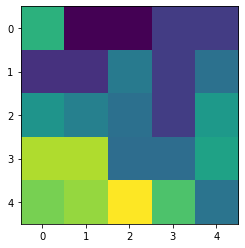

In [260]:
plt.imshow(res['Treeline']['img_arr'])

In [158]:
stat_ls = []
stid_ls = []
for stat in m.metadata(start = start_flight, end = end_flight, bbox = bounds)['STATION']:
    long = float(stat['LONGITUDE'])
    lat = float(stat['LATITUDE'])
    with rio.open(fp) as src:
        w = raster_box_extract(src, long, lat)
    if len(w[~np.isnan(w)]) > 0:
        if stat['NAME'].lower().replace(' ','') not in stat_ls:

            stat = m.timeseries(start_flight, end_flight, stid = stat['STID'])
            res = {}
            d = {}
            obs = stat['OBSERVATIONS']

            dt = pd.to_datetime(obs['date_time'])
            if 'snow_depth_set_1' in obs.keys():
                d['datetime'] = dt
                d['snow_depth_set_1'] = obs['snow_depth_set_1']
                for anc_col in ['air_temp_set_1','snow_water_equiv_set_1']:
                    if anc_col in obs.keys():
                        d[anc_col] = obs[anc_col]
            if d:
                d['elev'] = stat['ELEVATION']
                d['lat'] = stat['LATITUDE']
                d['long'] = stat['LONGITUDE']
                d['tz'] = stat['TIMEZONE']
                res[stat['NAME']] = d
        stat_ls.append(stat['NAME'].lower().replace(' ',''))

In [227]:
a = m.timeseries(start = start_flight, end = end_flight, stid = stid_ls)

res = {}
for stat in a['STATION']:
    # print(stat['SENSOR_VARIABLES'])
    d = {}
    obs = stat['OBSERVATIONS']

    dt = pd.to_datetime(obs['date_time'])
    if 'snow_depth_set_1' in obs.keys():
        d['datetime'] = dt
        d['snow_depth_set_1'] = obs['snow_depth_set_1']
        for anc_col in ['air_temp_set_1','snow_water_equiv_set_1']:
            if anc_col in obs.keys():
                d[anc_col] = obs[anc_col]
    if d:
        d['elev'] = stat['ELEVATION']
        d['lat'] = stat['LATITUDE']
        d['long'] = stat['LONGITUDE']
        d['tz'] = stat['TIMEZONE']
        res[stat['NAME']] = d

In [270]:
for col in ann_df.columns:
    if 'acq' in col:
        print(col)

acquisition mode
start time of acquisition for pass 1
stop time of acquisition for pass 1
start time of acquisition for pass 2
stop time of acquisition for pass 2


In [277]:
ann_df = pd.read_csv('/home/zacharykeskinen/uavsar/data/slc_stack/lowman_23205_20002-007_20007-003_0013d_s01_L090_01_int_grd/lowman_23205_20002-007_20007-003_0013d_s01_L090_01_int_grd.csv')
start = pd.to_datetime(ann_df['stop time of acquisition for pass 1'][0])
end = pd.to_datetime(ann_df['start time of acquisition for pass 2'][0])

In [311]:
def mesopy_date_parse(pd_date_str):
    return pd_date_str.strftime('%Y') + pd_date_str.strftime('%m') + pd_date_str.strftime('%d') + pd_date_str.strftime('%H') + pd_date_str.strftime('%M')

In [313]:
mesopy_date_parse(pd.to_datetime('2020-10-04T20:30'))

'202010042030'

In [295]:
import datetime
isinstance((pd.to_datetime('2020-10-01')), datetime.datetime)


True

In [280]:
start.month

12

In [100]:
start_flight = '202001010000'
end_flight = '202001070000'
a = m.timeseries(start_flight, end_flight, stid = 'BASI1' )
dt = a['STATION'][0]['OBSERVATIONS']['date_time']
sd = a['STATION'][0]['OBSERVATIONS']['snow_depth_set_1']
swe = a['STATION'][0]['OBSERVATIONS']['snow_water_equiv_set_1']
temp = a['STATION'][0]['OBSERVATIONS']['air_temp_set_1']
a['STATION'][0]['OBSERVATIONS'].keys()

dict_keys(['date_time', 'precip_accum_set_1', 'air_temp_set_1', 'snow_depth_set_1', 'snow_water_equiv_set_1'])

In [123]:
from rasterio.windows import Window    
with rio.open(fp) as src:
    meta = src.meta

    # My target coordinates
    x_coord = -115.23447
    y_coord = 44.30342

    # Use the transform in the metadata and your coordinates
    rowcol = rio.transform.rowcol(meta['transform'], xs=x_coord, ys=y_coord)

    w = src.read(1, window=Window(rowcol[1], rowcol[0], 5, 5))
    # Do something with your data here.
    print(w)

[[0.5484348  0.31308866 0.31308866 0.6165717  0.4401617 ]
 [0.31507125 0.31507125 0.18963079 0.18963079 0.38096958]
 [0.6648995  0.5150316  0.5150316  0.2932993  0.2932993 ]
 [0.6648995  0.27879265 0.29156768 0.5121335  0.261881  ]
 [0.42498717 0.27879265 0.4513048  0.5121335  0.5501685 ]]
